In [52]:
from IPython.display import Image
import matplotlib.pyplot as plt
import sys
import pickle
from sklearn import preprocessing
from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
sys.path.append("../tools/")


from feature_format import featureFormat
from feature_format import targetFeatureSplit

### features_list is a list of strings, each of which is a feature name
### first feature must be "poi", as this will be singled out as the label
features_list = ["poi"]

### load the dictionary containing the dataset
data_dict = pickle.load(open("final_project_dataset.pkl", "r") )

In [53]:
#!/usr/bin/python

""" 
    A general tool for converting data from the
    dictionary format to an (n x k) python list that's 
    ready for training an sklearn algorithm

    n--no. of key-value pairs in dictonary
    k--no. of features being extracted

    dictionary keys are names of persons in dataset
    dictionary values are dictionaries, where each
        key-value pair in the dict is the name
        of a feature, and its value for that person

    In addition to converting a dictionary to a numpy 
    array, you may want to separate the labels from the
    features--this is what targetFeatureSplit is for

    so, if you want to have the poi label as the target,
    and the features you want to use are the person's
    salary and bonus, here's what you would do:

    feature_list = ["poi", "salary", "bonus"] 
    data_array = featureFormat( data_dictionary, feature_list )
    label, features = targetFeatureSplit(data_array)

    the line above (targetFeatureSplit) assumes that the
    label is the _first_ item in feature_list--very important
    that poi is listed first!
"""


import numpy as np

def featureFormat( dictionary, features, remove_NaN=True, remove_all_zeroes=True, remove_any_zeroes=False, sort_keys = False):
    """ convert dictionary to numpy array of features
        remove_NaN = True will convert "NaN" string to 0.0
        remove_all_zeroes = True will omit any data points for which
            all the features you seek are 0.0
        remove_any_zeroes = True will omit any data points for which
            any of the features you seek are 0.0
        sort_keys = True sorts keys by alphabetical order. Setting the value as
            a string opens the corresponding pickle file with a preset key
            order (this is used for Python 3 compatibility, and sort_keys
            should be left as False for the course mini-projects).
        NOTE: first feature is assumed to be 'poi' and is not checked for
            removal for zero or missing values.
    """


    return_list = []

    # Key order - first branch is for Python 3 compatibility on mini-projects,
    # second branch is for compatibility on final project.
    if isinstance(sort_keys, str):
        import pickle
        keys = pickle.load(open(sort_keys, "rb"))
    elif sort_keys:
        keys = sorted(dictionary.keys())
    else:
        keys = dictionary.keys()

    for key in keys:
        tmp_list = []
        for feature in features:
            try:
                dictionary[key][feature]
            except KeyError:
                print "error: key ", feature, " not present"
                return
            value = dictionary[key][feature]
            if value=="NaN" and remove_NaN:
                value = 0
            tmp_list.append( float(value) )

        # Logic for deciding whether or not to add the data point.
        append = True
        # exclude 'poi' class as criteria.
        if features[0] == 'poi':
            test_list = tmp_list[1:]
        else:
            test_list = tmp_list
        ### if all features are zero and you want to remove
        ### data points that are all zero, do that here
        if remove_all_zeroes:
            append = False
            for item in test_list:
                if item != 0 and item != "NaN":
                    append = True
                    break
        ### if any features for a given data point are zero
        ### and you want to remove data points with any zeroes,
        ### handle that here
        if remove_any_zeroes:
            if 0 in test_list or "NaN" in test_list:
                append = False
        ### Append the data point if flagged for addition.
        if append:
            return_list.append( np.array(tmp_list) )

    return np.array(return_list)


def targetFeatureSplit( data ):
    """ 
        given a numpy array like the one returned from
        featureFormat, separate out the first feature
        and put it into its own list (this should be the 
        quantity you want to predict)

        return targets and features as separate lists

        (sklearn can generally handle both lists and numpy arrays as 
        input formats when training/predicting)
    """

    target = []
    features = []
    for item in data:
        target.append( item[0] )
        features.append( item[1:] )

    return target, features



In [54]:
print "There are ", len(data_dict.keys()), " executives in Enron Dataset."

There are  146  executives in Enron Dataset.


In [55]:
print "there are",set(len(v) for v in data_dict.values()), "features"

there are set([21]) features


In [56]:
my_dataset = data_dict
print "There are ", len(my_dataset['BUY RICHARD B']), " samples in Enron Dataset."

There are  21  samples in Enron Dataset.


In [57]:
my_dataset['SKILLING JEFFREY K']

{'bonus': 5600000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'jeff.skilling@enron.com',
 'exercised_stock_options': 19250000,
 'expenses': 29336,
 'from_messages': 108,
 'from_poi_to_this_person': 88,
 'from_this_person_to_poi': 30,
 'loan_advances': 'NaN',
 'long_term_incentive': 1920000,
 'other': 22122,
 'poi': True,
 'restricted_stock': 6843672,
 'restricted_stock_deferred': 'NaN',
 'salary': 1111258,
 'shared_receipt_with_poi': 2042,
 'to_messages': 3627,
 'total_payments': 8682716,
 'total_stock_value': 26093672}

In [58]:

%matplotlib inline
features = ["salary", "bonus"]
#data_dict.pop('TOTAL', 0)
data = featureFormat(data_dict, features)
### plot features
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

In [59]:
### remove any outliers before proceeding further
features = ["salary", "bonus"]
data_dict.pop('TOTAL', 0)
data = featureFormat(data_dict, features)

### remove NAN's from dataset
outliers = []
for key in data_dict:
    val = data_dict[key]['salary']
    if val == 'NaN':
        continue
    outliers.append((key, int(val)))

outliers_final = (sorted(outliers,key=lambda x:x[1],reverse=True)[:4])
### print top 4 salaries
print outliers_final

[('SKILLING JEFFREY K', 1111258), ('LAY KENNETH L', 1072321), ('FREVERT MARK A', 1060932), ('PICKERING MARK R', 655037)]


In [60]:
outliers

[('METTS MARK', 365788),
 ('BAXTER JOHN C', 267102),
 ('ELLIOTT STEVEN', 170941),
 ('HANNON KEVIN P', 243293),
 ('MORDAUNT KRISTINA M', 267093),
 ('MCMAHON JEFFREY', 370448),
 ('PIPER GREGORY F', 197091),
 ('HUMPHREY GENE E', 130724),
 ('UMANOFF ADAM S', 288589),
 ('BLACHMAN JEREMY M', 248546),
 ('SUNDE MARTIN', 257486),
 ('COLWELL WESLEY', 288542),
 ('MULLER MARK S', 251654),
 ('JACKSON CHARLENE R', 288558),
 ('WESTFAHL RICHARD K', 63744),
 ('WALLS JR ROBERT H', 357091),
 ('KITCHEN LOUISE', 271442),
 ('SHANKMAN JEFFREY A', 304110),
 ('BERGSIEKER RICHARD P', 187922),
 ('BIBI PHILIPPE A', 213625),
 ('RIEKER PAULA H', 249201),
 ('BECK SALLY W', 231330),
 ('ECHOLS JOHN B', 182245),
 ('HICKERSON GARY J', 211788),
 ('KOPPER MICHAEL J', 224305),
 ('LEFF DANIEL P', 273746),
 ('LAVORATO JOHN J', 339288),
 ('BERBERIAN DAVID', 216582),
 ('DETMERING TIMOTHY J', 210500),
 ('GOLD JOSEPH', 272880),
 ('BANNANTINE JAMES M', 477),
 ('SHAPIRO RICHARD S', 269076),
 ('SHERRIFF JOHN R', 428780),
 ('SHELBY 

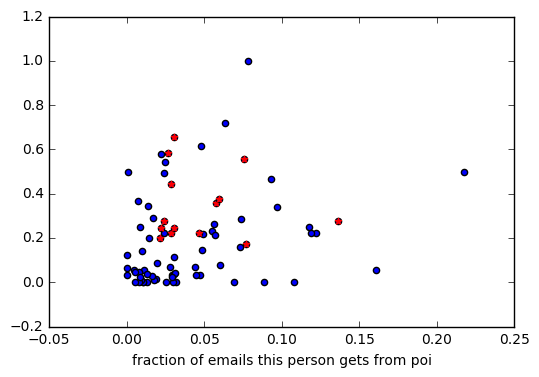

In [61]:

def dict_to_list(key,normalizer):
    new_list=[]

    for i in data_dict:
        if data_dict[i][key]=="NaN" or data_dict[i][normalizer]=="NaN":
            new_list.append(0.)
        elif data_dict[i][key]>=0:
            new_list.append(float(data_dict[i][key])/float(data_dict[i][normalizer]))
    return new_list

### create two lists of new features
poi_sender_fract=dict_to_list("from_poi_to_this_person","to_messages")
poi_recipient_fract=dict_to_list("from_this_person_to_poi","from_messages")

### insert new features into data_dict
count=0
for i in data_dict:
    data_dict[i]["poi_sender_fract"]=poi_sender_fract[count]
    data_dict[i]["poi_recipient_fract"]=poi_recipient_fract[count]
    count +=1

    
features_list = ["poi", "poi_sender_fract", "poi_recipient_fract"]    
    ### store to my_dataset for easy export below
my_dataset = data_dict


### these two lines extract the features specified in features_list
### and extract them from data_dict, returning a numpy array
data = featureFormat(my_dataset, features_list)

### plot new features
for point in data:
    from_poi = point[1]
    to_poi = point[2]
    plt.scatter( from_poi, to_poi )
    if point[0] == 1:
        plt.scatter(from_poi, to_poi, color="r", marker="*")
plt.xlabel("fraction of emails this person gets from poi")
plt.show()

In [62]:
email_array = []
for x in data_dict.values():
    if x['email_address'] == 'NaN':
        email_array.append(x['email_address'])
        
print len(email_array), "has email address"

34 has email address


In [63]:
NA_salary = []
for x in data_dict.values():
    if x['salary'] != 'NaN':
        NA_salary.append(x['salary'])
len(NA_salary),"have a quantified salary from this dataset"

(94, 'have a quantified salary from this dataset')

In [64]:
features_list = ["poi", "salary", "bonus", "poi_sender_fract", "poi_recipient_fract",
                 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options',
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']
data = featureFormat(data_dict, features_list)

### split into labels and features (this line assumes that the first
### feature in the array is the label, which is why "poi" must always
### be first in features_list
labels, features = targetFeatureSplit(data)

### split data into training and testing datasets
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)


from sklearn.tree import DecisionTreeClassifier

t0 = time()

clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
pred= clf.predict(features_test)
print 'accuracy', score

print "Decision tree algorithm time:", round(time()-t0, 3), "s"



importances = clf.feature_importances_
import numpy as np
indices = np.argsort(importances)[::-1]
print 'Feature Ranking: '
for i in range(16):
    print "{} feature {} ({})".format(i+1,features_list[i+1],importances[indices[i]])

accuracy 0.733333333333
Decision tree algorithm time: 0.003 s
Feature Ranking: 
1 feature salary (0.211707133446)
2 feature bonus (0.14622972935)
3 feature poi_sender_fract (0.141886645963)
4 feature poi_recipient_fract (0.14139568871)
5 feature deferral_payments (0.128198757764)
6 feature total_payments (0.118337314859)
7 feature loan_advances (0.0745332011969)
8 feature restricted_stock_deferred (0.0377115287109)
9 feature deferred_income (0.0)
10 feature total_stock_value (0.0)
11 feature expenses (0.0)
12 feature exercised_stock_options (0.0)
13 feature long_term_incentive (0.0)
14 feature shared_receipt_with_poi (0.0)
15 feature restricted_stock (0.0)
16 feature director_fees (0.0)


The 8 features I pick would be:
["salary", "bonus", "fraction_from_poi_email", "fraction_to_poi_email", 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred']


In [65]:

features_list = ["poi", "poi_sender_fract", "poi_recipient_fract", "shared_receipt_with_poi"]
### try Naive Bayes for prediction
t0 = time()

clf = GaussianNB()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
accuracy = accuracy_score(pred,labels_test)
print accuracy

print "NB algorithm time:", round(time()-t0, 3), "s"

0.266666666667
NB algorithm time: 0.003 s


In [78]:

### use manual tuning parameter min_samples_split
clf = DecisionTreeClassifier(min_samples_split=5)
print clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


In [76]:
### features_list is a list of strings, each of which is a feature name
### first feature must be "poi", as this will be singled out as the label
#features_list = ["poi", "fraction_from_poi_email", "fraction_to_poi_email", 'shared_receipt_with_poi']
features_list = ["poi", "poi_sender_fract", "poi_recipient_fract", "shared_receipt_with_poi"]

### store to my_dataset for easy export below
my_dataset = data_dict


### these two lines extract the features specified in features_list
### and extract them from data_dict, returning a numpy array
data = featureFormat(my_dataset, features_list)


### split into labels and features (this line assumes that the first
### feature in the array is the label, which is why "poi" must always
### be first in features_list
labels, features = targetFeatureSplit(data)


### machine learning goes here!
### please name your classifier clf for easy export below

### deploying feature selection
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)

### use KFold for split and validate algorithm
from sklearn.cross_validation import KFold
kf=KFold(len(labels),3)
for train_indices, test_indices in kf:
    #make training and testing sets
    features_train= [features[ii] for ii in train_indices]
    features_test= [features[ii] for ii in test_indices]
    labels_train=[labels[ii] for ii in train_indices]
    labels_test=[labels[ii] for ii in test_indices]

from sklearn.tree import DecisionTreeClassifier

t0 = time()

clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
print 'accuracy before tuning ', score

print "Decision tree algorithm time:", round(time()-t0, 3), "s"


### use manual tuning parameter min_samples_split
t0 = time()
clf = DecisionTreeClassifier(min_samples_split=5)
clf = clf.fit(features_train,labels_train)
pred= clf.predict(features_test)
print("done in %0.3fs" % (time() - t0))

acc=accuracy_score(labels_test, pred)

print "Validating algorithm:"
print "accuracy after tuning = ", acc

# function for calculation ratio of true positives
# out of all positives (true + false)
print 'precision = ', precision_score(labels_test,pred)

# function for calculation ratio of true positives
# out of true positives and false negatives
print 'recall = ', recall_score(labels_test,pred)


### dump your classifier, dataset and features_list so
### anyone can run/check your results
pickle.dump(clf, open("my_classifier.pkl", "w") )
pickle.dump(data_dict, open("my_dataset.pkl", "w") )
pickle.dump(features_list, open("my_feature_list.pkl", "w") )

accuracy before tuning  0.857142857143
Decision tree algorithm time: 0.003 s
done in 0.001s
Validating algorithm:
accuracy after tuning =  0.892857142857
precision =  0.5
recall =  0.666666666667


In [80]:
import pickle
import sys
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.cross_validation import StratifiedShuffleSplit
from feature_format import featureFormat, targetFeatureSplit

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    #Added min max scaler here
    from sklearn.preprocessing import MinMaxScaler
    min_max_scaler = MinMaxScaler()
    features = min_max_scaler.fit_transform(features)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            else:
                true_positives += 1
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf

CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    pickle.dump(clf, open(CLF_PICKLE_FILENAME, "w") )
    pickle.dump(dataset, open(DATASET_PICKLE_FILENAME, "w") )
    pickle.dump(feature_list, open(FEATURE_LIST_FILENAME, "w") )

def load_classifier_and_data():
    clf = pickle.load(open(CLF_PICKLE_FILENAME, "r") )
    dataset = pickle.load(open(DATASET_PICKLE_FILENAME, "r") )
    feature_list = pickle.load(open(FEATURE_LIST_FILENAME, "r"))
    return clf, dataset, feature_list

def main():
    ### load up student's classifier, dataset, and feature_list
    clf, dataset, feature_list = load_classifier_and_data()
    ### Run testing script
    test_classifier(clf, dataset, feature_list)

if __name__ == '__main__':
    main()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Got a divide by zero when trying out: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


In [17]:
ref: 
    https://cs224d.stanford.edu/reports/Mahendra.pdf
        

SyntaxError: invalid syntax (<ipython-input-17-b91cf0b3b561>, line 1)